# Neural Networks for Data Science Applications

## Lab session 3: Feedforward networks with tf.data and tf.layers

**Contents of the lab session:**

* Building a feedforward neural networks on a realistic binary classification task.
* Using tf.data to iterate on the dataset.
* Using tf.layers to build a model by stacking several components.
* The high-level Keras compile/fit interface.

In [1]:
# We are making use of the GPU here, so remember to enable it on Colab by:
# Runtime >> Change runtime type >> Hardware accelerator (before starting the VM).
!pip install -q tensorflow-gpu==2.0.0

     |████████████████████████████████| 380.8MB 74kB/s 
     |████████████████████████████████| 3.8MB 32.3MB/s 
     |████████████████████████████████| 450kB 52.0MB/s 
ERROR: tensorflow 1.15.0rc3 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.0 which is incompatible.
ERROR: tensorflow 1.15.0rc3 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.0 which is incompatible.


## Load the dataset with tf.data

We'll do classification of super-symmetric particles from simulated particle collision experiments.

+ The dataset is here: https://archive.ics.uci.edu/ml/datasets/SUSY
+ Before starting, it is *highly advisable* to read the reference paper: https://www.nature.com/articles/ncomms5308.

In [2]:
# Download the dataset
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00279/SUSY.csv.gz

--2019-10-18 17:17:36--  https://archive.ics.uci.edu/ml/machine-learning-databases/00279/SUSY.csv.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 922377711 (880M) [application/x-httpd-php]
Saving to: ‘SUSY.csv.gz’

SUSY.csv.gz         100%[===================>] 879.65M  22.2MB/s    in 41s     

2019-10-18 17:18:17 (21.7 MB/s) - ‘SUSY.csv.gz’ saved [922377711/922377711]



In [0]:
# Unzip the .gz file
!gzip -d SUSY.csv.gz

In [4]:
!ls

sample_data  SUSY.csv


In [0]:
# Load with pandas
import pandas as pd
susy = pd.read_csv('SUSY.csv', header=None)

In [6]:
# Inspect the first five rows:
# Column 0 is the desired target.
# Columns 1-18 are the input features for the task (both low-level and high-level, see the reference paper).
susy.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.0,0.972861,0.653855,1.176225,1.157156,-1.739873,-0.874309,0.567765,-0.175000,0.810061,-0.252552,1.921887,0.889637,0.410772,1.145621,1.932632,0.994464,1.367815,0.040714
1,1.0,1.667973,0.064191,-1.225171,0.506102,-0.338939,1.672543,3.475464,-1.219136,0.012955,3.775174,1.045977,0.568051,0.481928,0.000000,0.448410,0.205356,1.321893,0.377584
2,1.0,0.444840,-0.134298,-0.709972,0.451719,-1.613871,-0.768661,1.219918,0.504026,1.831248,-0.431385,0.526283,0.941514,1.587535,2.024308,0.603498,1.562374,1.135454,0.180910
3,1.0,0.381256,-0.976145,0.693152,0.448959,0.891753,-0.677328,2.033060,1.533041,3.046260,-1.005285,0.569386,1.015211,1.582217,1.551914,0.761215,1.715464,1.492257,0.090719
4,1.0,1.309996,-0.690089,-0.676259,1.589283,-0.693326,0.622907,1.087562,-0.381742,0.589204,1.365479,1.179295,0.968218,0.728563,0.000000,1.083158,0.043429,1.154854,0.094859


In [0]:
# For this run, we only use 100k for training
import numpy as np
X = susy.values[0:100000, 1:].astype(np.float32) # Note the casting to float32
y = susy.values[0:100000, 0:1]

(array([54025., 45975.]), array([0. , 0.5, 1. ]), <a list of 2 Patch objects>)

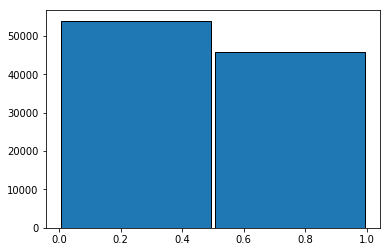

In [16]:
# Check that the classes are balanced
import matplotlib.pyplot as plt
plt.hist(y, bins=2, rwidth=0.98, ec='black')

In [0]:
import tensorflow as tf

In [0]:
# Learn more about tf.data here:
# https://www.tensorflow.org/guide/data
# In this case, from_tensor_slices allows us to iterate over batches of (X, y) simultaneously.
train_susy = tf.data.Dataset.from_tensor_slices((X, y))

In [20]:
for xb, yb in train_susy.batch(4):
  print(xb.shape)
  print(yb)
  break

(4, 18)
tf.Tensor(
[[0.]
 [1.]
 [1.]
 [1.]], shape=(4, 1), dtype=float64)


In [0]:
# Or, to get values programmatically:
xb, yb = next(iter(train_susy.batch(4)))

## Model building with tf.layers

In [0]:
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential

In [0]:
# A feedforward neural network with a single hidden layer
# TODO: experiment!
def build_model():
  net = Sequential()
  net.add(Dense(50, activation='sigmoid'))
  net.add(Dense(1, activation='sigmoid'))
  return net

In [0]:
net = build_model()

In [25]:
# The variables of the network are initialized on first call,
# because we have not specified an input shape anywhere.
net(xb)

<tf.Tensor: id=77, shape=(4, 1), dtype=float32, numpy=
array([[0.62104535],
       [0.5071169 ],
       [0.52204525],
       [0.43793625]], dtype=float32)>

In [0]:
net.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              multiple                  950       
_________________________________________________________________
dense_3 (Dense)              multiple                  51        
Total params: 1,001
Trainable params: 1,001
Non-trainable params: 0
_________________________________________________________________


In [26]:
# The model is:
# h = sigmoid( W * x + b )
# y = sigmoid( v * h + c )
# net.variables is [W, b, v, c]
len(net.variables)

4

## Model training (custom loop)

In [0]:
from tensorflow.keras import losses, optimizers

In [0]:
from tqdm import tqdm_notebook

In [0]:
# Like last lab session, no changes
loss = losses.BinaryCrossentropy()
opt = optimizers.Adam()

In [30]:
loss_history = []
for epoch in tqdm_notebook(range(3)):
  
  for xb, yb in train_susy.shuffle(10000).batch(32): # The dataset is shuffled and batched at every epoch
    
      with tf.GradientTape() as tape:
        ypred = net(xb)
        l = loss(yb, ypred)
        
      # We need to get gradient on all variables
      g = tape.gradient(l, net.variables)
      # 'zip' provides us a list of (gradient, variable)
      opt.apply_gradients(zip(g, net.variables))
      
      loss_history.append(l.numpy())

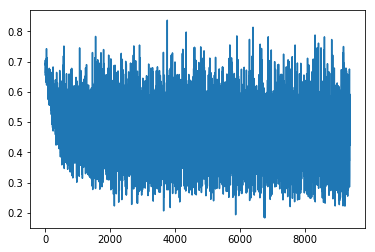

In [31]:
# Noisy!
plt.plot(loss_history)

In [0]:
# Pandas provides some utilities to smooth a time series
loss_pd = pd.Series(loss_history).ewm(halflife=50)

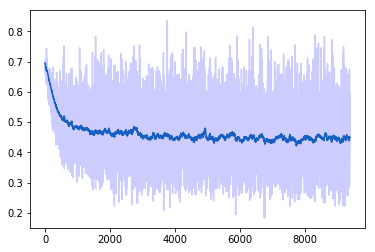

In [33]:
plt.plot(loss_pd.mean())
plt.plot(loss_history, 'b', alpha=0.2)

## Evaluating the model

In [0]:
# We use a separate set of 100k values
Xtest = susy.values[100000:200000, 1:].astype(np.float32)
ytest = susy.values[100000:200000, 0:1]

In [0]:
test_susy = tf.data.Dataset.from_tensor_slices((Xtest, ytest))

In [0]:
from tensorflow.keras import metrics

In [0]:
# Accumulate a running average of the accuracy on all batches
acc = metrics.BinaryAccuracy()
for xb, yb in test_susy.batch(32):
  acc(yb, net(xb))

In [38]:
acc.result()

<tf.Tensor: id=1362757, shape=(), dtype=float32, numpy=0.79808>

## High-level training with compile/fit

In [0]:
# We re-initialize the model
net =  build_model()

In [0]:
# Compile provides all the custom blocks for training:
# - loss (BinaryCrossEntropy)
# - optimizer (Adam)
# - metrics (BinaryAccuracy and AUC)
# We use AUC to compare with the original paper. Note that computing AUC from mini-batches is not-trivial:
# https://www.tensorflow.org/api_docs/python/tf/keras/metrics/AUC
net.compile(optimizer=opt, loss=loss, 
           metrics = [
               metrics.BinaryAccuracy(),
               metrics.AUC()
           ])

In [0]:
# Same as before, this time with tracking of metrics
history = net.fit(train_susy.shuffle(1000).batch(32), epochs=3)

Epoch 1/3
3125/3125 [==============================] - 26s 8ms/step - loss: 0.4667 - binary_accuracy: 0.7821 - auc_1: 0.8512
Epoch 2/3
3125/3125 [==============================] - 15s 5ms/step - loss: 0.4472 - binary_accuracy: 0.7924 - auc_1: 0.8636
Epoch 3/3
3125/3125 [==============================] - 16s 5ms/step - loss: 0.4436 - binary_accuracy: 0.7941 - auc_1: 0.8659


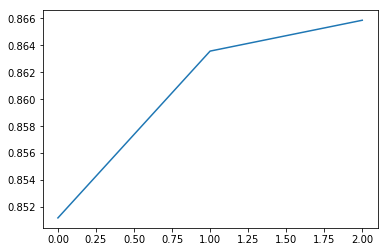

In [0]:
plt.plot(history.history['auc_1'])

In [0]:
# We remove the last dimension from y
test_susy = tf.data.Dataset.from_tensor_slices((Xtest, 
                                                ytest.reshape(-1)))

In [0]:
# Evaluate returns [loss, accuracy, auc], because this is how we compiled our model
net.evaluate(test_susy.batch(32))

3125/3125 [==============================] - 12s 4ms/step - loss: 0.7228 - binary_accuracy: 0.4232 - auc: 0.3994


[0.722752448348999, 0.42315, 0.3994017]